In [1]:
import os
os.chdir("/home/v-runmao/projects/R-Drop/vit_src/amlt/results/")

In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [30]:
def parse_ab_from_job_name(name, pat=None):
    if pat is None:  # default: parse `a` and `b`
        pat = "a([\d.]*\d+)b([\d.]*\d+)"
    matches = re.findall(pat, name)
    assert len(matches) == 1
    a, b = matches[0]
    a, b = float(a), float(b)
    return a, b


def get_best_valid_acc(log_file):
    acc = []
    s = "Valid Accuracy"
    with open(log_file, "r") as fi:
        for line in fi:
            if s not in line:
                continue
            matches = re.findall(f"{s}: (0\.\d+)", line)
            assert len(matches) == 1
            acc.append(float(matches[0]))
    
    if len(acc) == 0:
        with open(log_file, "r") as fi:
            for line in fi:
                if "Best Accuracy" not in line:
                    continue
                matches = re.findall("Best Accuracy:\s*([\d.]*\d+)", line)
                try:
                    assert len(matches) > 0
                except:
                    print(line)
                    raise
                acc.extend([float(m) for m in matches])
                
    return max(acc) if len(acc) > 0 else 0


def get_sorted_jobs(root, job_filter=None, re_pat=None):
    all_jobs = os.listdir(root)
    results = []
    avoid_dup = set()
    for j in all_jobs:
        if job_filter is not None and not job_filter(j):
            continue
        a, b = parse_ab_from_job_name(j, pat=re_pat)
        
        if (a, b) in avoid_dup:
            raise RuntimeError
        avoid_dup.add((a, b))
        
        acc = get_best_valid_acc(os.path.join(root, j, "stdout.txt"))
        results.append([(a, b), acc])
    return sorted(results, key=lambda x: x[1], reverse=True)


def display_jobs(root, res=None):
    if res is None:
        res = []
    for j in os.listdir(root):
        acc = get_best_valid_acc(os.path.join(root, j, "stdout.txt"))
        res.append((j, acc))
    display(sorted(res, key=lambda x: x[1], reverse=True))


def vis_heat_map_ab(job_results):
    ab, acc = zip(*job_results)
    a, b = zip(*ab)
    
    # get rank of alpha and betas => get integers
    x = pd.Series(a).rank(method="dense").values.astype(np.int32) - 1
    y = pd.Series(b).rank(method="dense").values.astype(np.int32) - 1
    acc = np.array(acc)
    
    # create heat map
    arr = np.zeros((x.max() + 1, y.max() + 1))
    arr[x, y] = acc
    
    # visualize
    fig, ax = plt.subplots(figsize=(12, 9))
    ax.imshow(arr)
    ax.set_xlabel("beta")
    ax.set_ylabel("alpha")
    all_alpha = np.sort(np.unique(a))
    all_beta = np.sort(np.unique(b))
    ax.set_xticks(range(len(all_beta)))
    ax.set_xticklabels(all_beta)
    ax.set_yticks(range(len(all_alpha)))
    ax.set_yticklabels(all_alpha)
    
    # set text
    for i in range(len(all_alpha)):
        for j in range(len(all_beta)):
            text = ax.text(j, i, arr[i, j], ha="center", va="center", color="r")
    return ax

# with Rand Augment

In [112]:
# job_res = get_sorted_jobs("ViTB16_search/",
#                           job_filter=lambda j: "RA" in j)

# _ = vis_heat_map_ab(job_res)

# without Rand Augment

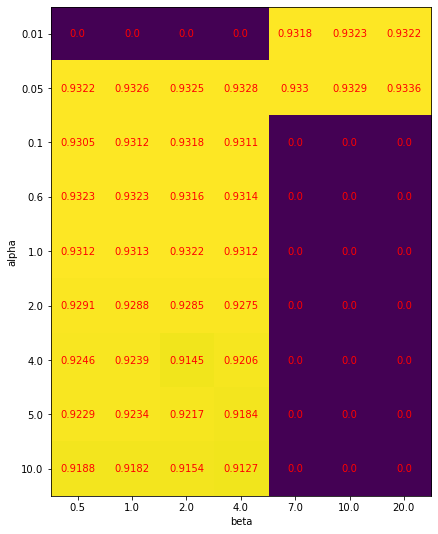

In [119]:
job_res = get_sorted_jobs("ViTB16_search/",
                          job_filter=lambda j: "RA" not in j)

_ = vis_heat_map_ab(job_res)

# compare different augs

In [114]:
# all_res = []
# for j in os.listdir("ViTB16_aug/"):
#     acc = get_best_valid_acc(os.path.join("ViTB16_aug", j, "stdout.txt"))
#     all_res.append((j, acc))
    
# display(sorted(all_res, key=lambda x: x[1], reverse=True))

# search learning rate and $\alpha$

In [108]:
# job_res = get_sorted_jobs("ViTB16_search_lr/", re_pat="a([\d.]*\d+)b1lr([\d.]*\d+)")

# ax = vis_heat_map_ab(job_res)
# ax.set_xlabel("lr")

# Search $\alpha$ and $\beta$ (new version)

In [45]:
display_jobs("ViTB16_newsearch/", res=[("a0.5b0.025", 0.9336)])

[('a1b0.1', 0.9345),
 ('a1b0.15', 0.9342),
 ('a1b0.05', 0.9342),
 ('a1.5b0.1', 0.9341),
 ('a1.5b0.075', 0.934),
 ('a1b0.075', 0.934),
 ('a1b0.025', 0.9339),
 ('a0.5b0.025', 0.9336),
 ('a1b0.125', 0.9335),
 ('a1.5b0.15', 0.9333),
 ('a1b0.01', 0.9333),
 ('a0.5b0.05', 0.9333),
 ('a1.5b0.125', 0.9332),
 ('a0.5b0.01', 0.9325),
 ('a0.3b0.01', 0.9325),
 ('rdropDA__a0.5_b0.025_koi', 0.9323),
 ('a0.3b0.05', 0.9269)]

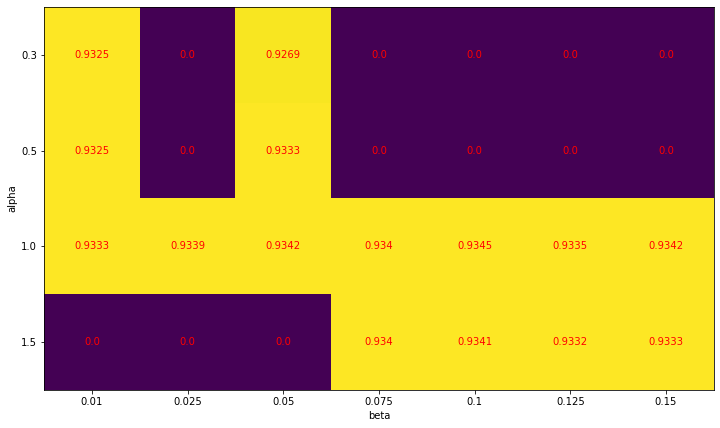

In [46]:
job_res = get_sorted_jobs("ViTB16_newsearch/",
                          job_filter=lambda j: "koi" not in j)

_ = vis_heat_map_ab(job_res)

# ViTB16 384x384 resolution

In [33]:
display_jobs("ViTB16_384")

[('a1b0.05_seed682', 0.927),
 ('a1b0.05_seed42', 0.9267),
 ('a0.5b0.05_seed682', 0.9262),
 ('a1b0.05_seed10', 0.9034),
 ('reso224', 0)]

# WRN stochastic depth

In [36]:
display_jobs("WRN_sd/", res=[("sd0.8", 0.807), ("baseline", 0.8118)])

[('sd0.9', 0.8168),
 ('baseline', 0.8118),
 ('sd0.8', 0.807),
 ('sd0.95', 0.799),
 ('sd0.7', 0.7983),
 ('sd0.6', 0.7888),
 ('sd0.5', 0.781)]

# WRN rdrop

In [37]:
display_jobs("WRN_rdrop/")

[('alpha2', 0.8172),
 ('alpha1', 0.8168),
 ('alpha3', 0.8162),
 ('alpha5', 0.8158),
 ('alpha6', 0.8156),
 ('alpha4', 0.8154)]

# Image Net

In [82]:
display_jobs("ViTB16_i1k")

[('vitb16_i1k_rdropDA_a0.5b0.1', 0.81972),
 ('vitb16_i1k_rdropDA_a1b0.1', 0.81902),
 ('vitb16_i1k_rdropDA_a0.5b0.5', 0.819),
 ('vitb16_i1k_rdropDA_a1b0.5', 0.8187),
 ('rdrop_a0.6', 0.8179),
 ('vitb16_i1k_rdropDA_a0.3b1', 0.81636),
 ('vitb16_i1k_rdropDA_a1b1', 0.81618),
 ('baseline', 0.81604)]

# Resnet110

## search alpha and beta

In [60]:
display_jobs("R110_search")

[('a0.3b1.5', 0.7784),
 ('a0.3b1', 0.7762),
 ('a1b1', 0.7759),
 ('a0.3b1.25', 0.7755),
 ('a0.5b1', 0.7745),
 ('a0.1b1', 0.7726),
 ('a0.3b0.5', 0.7705),
 ('a1b0.5', 0.7692),
 ('a1b0.1', 0.7687),
 ('a2b0.5', 0.7681),
 ('a0.5b0.1', 0.7642),
 ('a2b1', 0.7627),
 ('a2b0.1', 0.758),
 ('a0.1b0.5', 0.7424)]

## logit / prob

In [71]:
display_jobs("R110_func")

[('a0.5b0.5_ml2_dkl_randselect', 0.7883),
 ('a0.5b0.5_mkl_dl2_randselect', 0.7796),
 ('a0.5b0.5_ml2_dl2_randselect', 0.774),
 ('a0.3b1_ml2_dkl', 0.7692),
 ('a0.3b1_mkl_dl2', 0.7582),
 ('a0.3b1_ml2_dl2', 0.7567),
 ('a0.3b1_m-l2_d-kl', 0.6778),
 ('a0.3b1_m-l2_d-l2', 0.6637),
 ('a0.3b1_m-kl_d-l2', 0.6567),
 (':a0.5b1_m-kl_d-l2', 0.4984),
 (':a0.5b1_m-l2_d-l2', 0.06),
 (':a0.5b1_m-l2_d-kl', 0.0117)]

## compare augs

In [61]:
display_jobs("R110_aug", res=[('a0.5b0.5_randaug', 0.781),
                              ('a0.3b1_randaug', 0.7773)])

[('a0.3b1_randselect', 0.79),
 ('a0.5b0.5_randaug', 0.781),
 ('a0.3b1_randaug', 0.7773),
 ('a0.3b1_augmix', 0.7743)]

## ablation

In [78]:
display_jobs("R110_ablation", res=[('a0.3b1_randselect', 0.79),
                                   ('a0b0_randselect', 0.7801)])

[('a0b1_randselect', 0.7903),
 ('a0.3b1_randselect', 0.79),
 ('a0b0.5_randselect', 0.7867),
 ('a0.3b0_randselect', 0.7837),
 ('a0b0_randselect', 0.7801)]

## search alpha and beta with rand_select aug

In [74]:
display_jobs("R110_randselect_search", res=[("a0.3b1", 0.79),
                                            ("a0.3b1.5", 0.7829),
                                            ("a0.3b2", 0.7799),
                                            ("a0.3b0.5", 0.7933),
                                            ("a0.3b0.7", 0.7873)])

[('a0.3b0.5', 0.7933),
 ('a0.3b1', 0.79),
 ('a0.5b1', 0.79),
 ('a0.3b0.7', 0.7873),
 ('a0.5b0.5', 0.7869),
 ('a0.3b1.5', 0.7829),
 ('a0.5b1.5', 0.7809),
 ('a0.3b2', 0.7799),
 ('a1b1', 0.7781),
 ('a1b2', 0.7704),
 ('a0.5b2', 0.7699),
 ('a1b1.5', 0.7698)]